In [30]:
# CAP 5415 Programming Assignment 04: Image Classification

"""
Design a CNN architecture which has more then 2 convolutional layers and more then 1 fully connected layers. It should make 10 predictions for the 10 classes of CIFAR-10.

1. Train this network on CIFAR-10 for 30 epochs
2. Use Cross-Entropy Loss
3. SGD Optimizer
4. Softmax activation after the final fully connected layer.
5. Report Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs.

6. Finally, increase the number of conv layers in the above network and train again. Report the same numbers and plots again comparing with the first network.


"""



'\nDesign a CNN architecture which has more then 2 convolutional layers and more then 1 fully connected layers. It should make 10 predictions for the 10 classes of CIFAR-10.\n\n1. Train this network on CIFAR-10 for 30 epochs\n2. Use Cross-Entropy Loss\n3. SGD Optimizer\n4. Softmax activation after the final fully connected layer.\n5. Report Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs.\n\n6. Finally, increase the number of conv layers in the above network and train again. Report the same numbers and plots again comparing with the first network.\n\n\n'

In [31]:
# =======================================================#
# 1. Import basic Modules and Functions and set variables
# =======================================================#

import torch
import torch.nn as nn # All the Neural network models, loss functions
import torch.optim as optim # Optimization algorithms
import torch.nn.functional as F # All functions without parameters
from torch.utils.data import DataLoader # Easier dataset management such as minibatches
import torchvision.datasets as datasets # Standard datasets that can be used as test training data
import torchvision.transforms as transforms # Transformations that can be performed on the dataset
from torchinfo import summary
import matplotlib.pyplot as plt


# Import some packages for logging training and showing progress
from tqdm_loggable.auto import tqdm
from tqdm_loggable.tqdm_logging import tqdm_logging
import datetime
import logging


# Set up some basic logging to record traces of training
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        filename="output/output.txt" # Save log to a file
    )

tqdm_logging.set_level(logging.INFO)


# Hyperparameters
input_channels = 3
hidden_size = 100
num_classes= 10
learning_rate = 0.1
batch_size = 10
num_epochs = 30
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# ================================================================================#
# 2. Next insert two Convolutional Laters to the network built in previous step:
# ================================================================================#

class NN_2(nn.Module):
    def __init__(self,input_channels,hidden_size, num_classes):
        super(NN_2, self).__init__() # The Super keyword calls the initialization of the parent class
        
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=40,
                               kernel_size=(5,5),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.conv2 = nn.Conv2d(in_channels=40,
                               out_channels=40,
                               kernel_size=(5,5),
                               stride=(1,1),
                               padding=(0,0)
                               )
        self.pool = nn.MaxPool2d(kernel_size=(2,2),
                                  stride=(2,2)
        ) 
        self.fc1 = nn.Linear(40*5*5, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def num_flat_features(self,x):
        size = x.size()[1:] # all dimensions except batch dimension
        num_features = 1
        for s in size:
            num_features *=s

        return num_features

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = self.pool(x)
        x = F.sigmoid(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1,self.num_flat_features(x))
        x = F.softmax(self.fc1(x))
        x = self.fc2(x)

        return x

In [33]:
# =======================================================#
# 3. Load and prepare dataset:
# =======================================================#

train_dataset = datasets.CIFAR10(root='dataset/', 
               train=True, 
               transform=transforms.ToTensor(),
               download=True
               )#Transforms transforms numpy array to tensors so that pytorch can use the data


train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_dataset = datasets.CIFAR10(root='dataset/', 
               train=False, 
               transform=transforms.ToTensor(),
               download=True
               )#Transforms transforms numpy array to tensors so that pytorch can use the data

test_loader = DataLoader(
    dataset= test_dataset,
    batch_size = batch_size,
    shuffle = True
)


Files already downloaded and verified
Files already downloaded and verified


In [34]:
# =======================================================#
# 4. Define Accuracy Function:
# =======================================================#

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
        logging.info("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")
        logging.info("Checking accuracy on test data")
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad(): # No gradients have to be calculated
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples) * 100:.2f}')
        logging.info(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples) * 100:.2f}')

    model.train()
    acc = float(num_correct)/float(num_samples)
    return acc

In [35]:
# =======================================================#
# 5. Train the Convolutional Neural Network:
# =======================================================#



#Initialize Model
model = NN_2(
    input_channels=input_channels,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device)

logging.info(f"Begin Training CIFAR-10 dataset with this model: {model}")

# Define the loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

# Set Some state variables
epoch_counter= 0
current_loss = 1
current_accuracy = 1
model_accuracy = []
model_loss = []


# Train Network
for epoch in range(num_epochs):
    if epoch > 0:
        current_accuracy = check_accuracy(train_loader,model)
        model_accuracy.append(current_accuracy)
        model_loss.append(round(current_loss, 4))
    tqdm.write(f"Step 1/2 Training Epoch {epoch+1}/{num_epochs}")
    # store points for for plotting the accuracy and loss:
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):

        
        # Get data to Cuda/gpu if possible
        data = data.to(device=device)
        targets = targets = targets.to(device=device)
    
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Go Backward in the network:
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        current_loss = loss.item()
        # logging.info("Training single layer Neural Network ")
        if epoch > epoch_counter+4:
            logging.info(f"Training Epoch: {epoch}, loss = {loss.item():.4f}")

            epoch_counter = epoch


epoch_counter = 0

print(f'Model Accuracy: {model_accuracy}')
print(f'Model Loss: {model_loss}')

# Save the trained model
torch.save(model.state_dict(),'trained_models/Classifier_01.pth')

Step 1/2 Training Epoch 1/30


  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_13182/1549013987.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))
100%|██████████| 5000/5000 [00:16<00:00, 303.93it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 2/30


100%|██████████| 5000/5000 [00:16<00:00, 295.48it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 3/30


100%|██████████| 5000/5000 [00:21<00:00, 236.92it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 4/30


100%|██████████| 5000/5000 [00:20<00:00, 238.87it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 5/30


100%|██████████| 5000/5000 [00:20<00:00, 244.11it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 6/30


100%|██████████| 5000/5000 [00:20<00:00, 244.59it/s]


Checking accuracy on training data
Got 5000 / 50000 with accuracy 10.00
Step 1/2 Training Epoch 7/30


100%|██████████| 5000/5000 [00:20<00:00, 244.36it/s]


Checking accuracy on training data
Got 9858 / 50000 with accuracy 19.72
Step 1/2 Training Epoch 8/30


100%|██████████| 5000/5000 [00:20<00:00, 243.90it/s]


Checking accuracy on training data
Got 12285 / 50000 with accuracy 24.57
Step 1/2 Training Epoch 9/30


100%|██████████| 5000/5000 [00:20<00:00, 246.47it/s]


Checking accuracy on training data
Got 14446 / 50000 with accuracy 28.89
Step 1/2 Training Epoch 10/30


100%|██████████| 5000/5000 [00:20<00:00, 247.56it/s]


Checking accuracy on training data
Got 15484 / 50000 with accuracy 30.97
Step 1/2 Training Epoch 11/30


100%|██████████| 5000/5000 [00:20<00:00, 242.93it/s]


Checking accuracy on training data
Got 16313 / 50000 with accuracy 32.63
Step 1/2 Training Epoch 12/30


100%|██████████| 5000/5000 [00:20<00:00, 246.11it/s]


Checking accuracy on training data
Got 18476 / 50000 with accuracy 36.95
Step 1/2 Training Epoch 13/30


100%|██████████| 5000/5000 [00:20<00:00, 244.03it/s]


Checking accuracy on training data
Got 19055 / 50000 with accuracy 38.11
Step 1/2 Training Epoch 14/30


100%|██████████| 5000/5000 [00:20<00:00, 242.71it/s]


Checking accuracy on training data
Got 22469 / 50000 with accuracy 44.94
Step 1/2 Training Epoch 15/30


100%|██████████| 5000/5000 [00:21<00:00, 235.80it/s]


Checking accuracy on training data
Got 21605 / 50000 with accuracy 43.21
Step 1/2 Training Epoch 16/30


100%|██████████| 5000/5000 [00:21<00:00, 235.11it/s]


Checking accuracy on training data
Got 23420 / 50000 with accuracy 46.84
Step 1/2 Training Epoch 17/30


100%|██████████| 5000/5000 [00:20<00:00, 242.63it/s]


Checking accuracy on training data
Got 24674 / 50000 with accuracy 49.35
Step 1/2 Training Epoch 18/30


100%|██████████| 5000/5000 [00:19<00:00, 251.95it/s]


Checking accuracy on training data
Got 24973 / 50000 with accuracy 49.95
Step 1/2 Training Epoch 19/30


100%|██████████| 5000/5000 [00:20<00:00, 240.56it/s]


Checking accuracy on training data
Got 25565 / 50000 with accuracy 51.13
Step 1/2 Training Epoch 20/30


100%|██████████| 5000/5000 [00:20<00:00, 240.65it/s]


Checking accuracy on training data
Got 25330 / 50000 with accuracy 50.66
Step 1/2 Training Epoch 21/30


100%|██████████| 5000/5000 [00:20<00:00, 242.56it/s]


Checking accuracy on training data
Got 25810 / 50000 with accuracy 51.62
Step 1/2 Training Epoch 22/30


100%|██████████| 5000/5000 [00:19<00:00, 251.96it/s]


Checking accuracy on training data
Got 27727 / 50000 with accuracy 55.45
Step 1/2 Training Epoch 23/30


100%|██████████| 5000/5000 [00:20<00:00, 243.74it/s]


Checking accuracy on training data
Got 25262 / 50000 with accuracy 50.52
Step 1/2 Training Epoch 24/30


100%|██████████| 5000/5000 [00:20<00:00, 242.36it/s]


Checking accuracy on training data
Got 28304 / 50000 with accuracy 56.61
Step 1/2 Training Epoch 25/30


100%|██████████| 5000/5000 [00:20<00:00, 242.82it/s]


Checking accuracy on training data
Got 28696 / 50000 with accuracy 57.39
Step 1/2 Training Epoch 26/30


100%|██████████| 5000/5000 [00:20<00:00, 242.21it/s]


Checking accuracy on training data
Got 29371 / 50000 with accuracy 58.74
Step 1/2 Training Epoch 27/30


100%|██████████| 5000/5000 [00:20<00:00, 242.74it/s]


Checking accuracy on training data
Got 28603 / 50000 with accuracy 57.21
Step 1/2 Training Epoch 28/30


100%|██████████| 5000/5000 [00:20<00:00, 243.30it/s]


Checking accuracy on training data
Got 29446 / 50000 with accuracy 58.89
Step 1/2 Training Epoch 29/30


100%|██████████| 5000/5000 [00:20<00:00, 243.33it/s]


Checking accuracy on training data
Got 29751 / 50000 with accuracy 59.50
Step 1/2 Training Epoch 30/30


100%|██████████| 5000/5000 [00:20<00:00, 241.65it/s]

Model Accuracy: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.19716, 0.2457, 0.28892, 0.30968, 0.32626, 0.36952, 0.3811, 0.44938, 0.4321, 0.4684, 0.49348, 0.49946, 0.5113, 0.5066, 0.5162, 0.55454, 0.50524, 0.56608, 0.57392, 0.58742, 0.57206, 0.58892, 0.59502]
Model Loss: [2.3081, 2.3182, 2.3145, 2.3104, 2.2867, 2.3132, 1.8284, 2.0291, 1.9334, 1.5315, 1.7073, 2.3038, 1.8059, 1.4252, 1.3368, 1.1439, 1.7041, 1.1771, 1.0059, 1.2168, 0.9874, 1.1912, 1.5767, 1.1552, 1.1328, 1.1765, 0.8723, 0.8573, 1.0339]


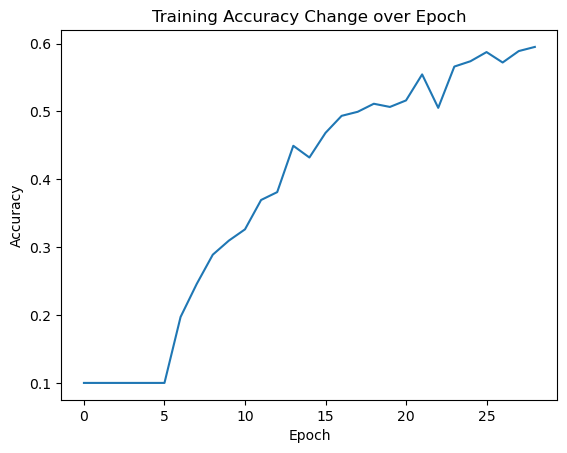

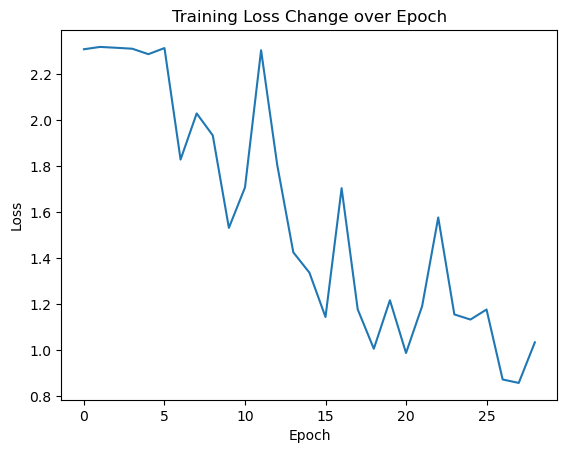

In [40]:
# =========================================================================================================#
# 7. Graph Training/Testing Loss after each epoch in the form of plots and accuracy scores after 30 epochs:
# =========================================================================================================#

epoch_list = []

for i in range(len(model_accuracy)):
    epoch_list.append(i)

# Plot Accuracy
plt.plot(epoch_list, model_accuracy)
plt.title("Training Accuracy Change over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Plot Loss
plt.plot(epoch_list, model_loss)
plt.title("Training Loss Change over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


